<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/CondyleClassification/blob/main/trail1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading standard Libraries and project modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

# 2. Load Data & Set Data Loaders

In [3]:
# Downloading dataset and unziping into proper folder structure
!rm -rf final_images
!wget -q https://github.com/DrVenkataRajeshKumar/CondyleClassification/releases/download/data1/final.images.zip
!unzip -q final.images.zip


## 2.1 Calculate mean and standard deviation for the data

In [4]:
find_mean_standard_deviation("final images/")

Sub-folders: ['class2', 'class3', 'class1', 'class4']
Mean: [0.43314943 0.43361538 0.43430133]
Std: [0.17610069 0.17660347 0.17742199]
Processing completed in 0m 1s


## 2.2 Load images in to DataSet and also perform data transforms

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadDataset('final images/', tstRatio = 0.3, batch_size = 20)

['class1', 'class2', 'class3', 'class4']
207
69
53
61


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


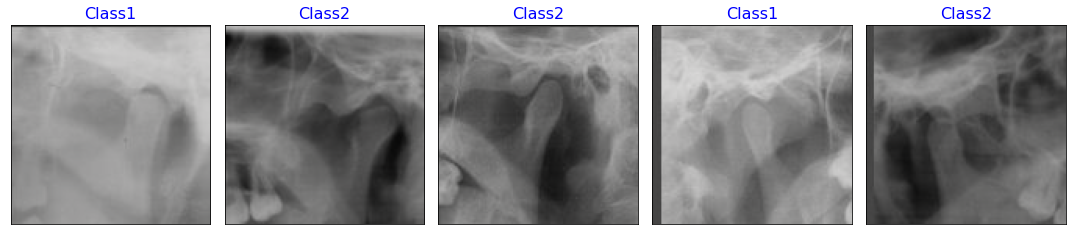

In [11]:
data.show_batch(save_as="sample.jpg")

# 4. Training Mobilenet Model - Only last layers
Modified last layer from 1000 classes to 4 and make only last layer trainable.
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [12]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Find hyper parameter lr value using LR Finder

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


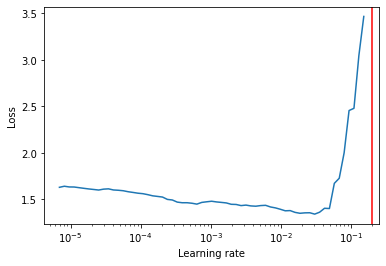

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.2) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.9, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

In [15]:
model_res, plotData = train_model(model_ft, data, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWa

train Loss: 98.8701 Acc: 0.3455
val Loss: 24.6615 Acc: 0.5478

Epoch 1/24
----------
train Loss: 92.1169 Acc: 0.3709
val Loss: 30.3862 Acc: 0.5391

Epoch 2/24
----------
train Loss: 60.4987 Acc: 0.4182
val Loss: 44.7611 Acc: 0.5391

Epoch 3/24
----------
train Loss: 64.3960 Acc: 0.4255
val Loss: 44.7226 Acc: 0.5652

Epoch 4/24
----------
train Loss: 45.6277 Acc: 0.4800
val Loss: 21.6874 Acc: 0.4957

Epoch 5/24
----------
train Loss: 46.3262 Acc: 0.4291
val Loss: 17.5056 Acc: 0.5043

Epoch 6/24
----------
train Loss: 45.6234 Acc: 0.4473
val Loss: 26.1495 Acc: 0.4435

Epoch 7/24
----------
train Loss: 48.4504 Acc: 0.4727
val Loss: 51.1389 Acc: 0.5391

Epoch 8/24
----------
train Loss: 38.1791 Acc: 0.4945
val Loss: 52.4965 Acc: 0.5391

Epoch 9/24
----------
train Loss: 37.2548 Acc: 0.4836
val Loss: 49.9433 Acc: 0.2348

Epoch 10/24
----------
train Loss: 53.9783 Acc: 0.4436
val Loss: 52.9853 Acc: 0.5391

Epoch 11/24
----------
train Loss: 32.4963 Acc: 0.5855
val Loss: 58.5073 Acc: 0.5391



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


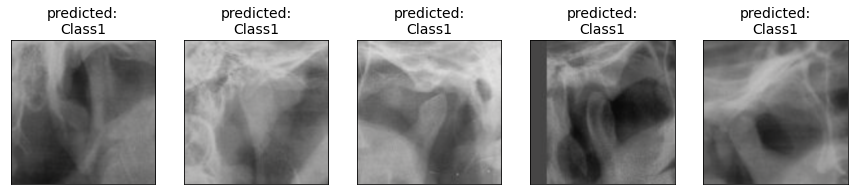

In [16]:
visualize_model(model_res, data, device,"visualize_1.jpg")

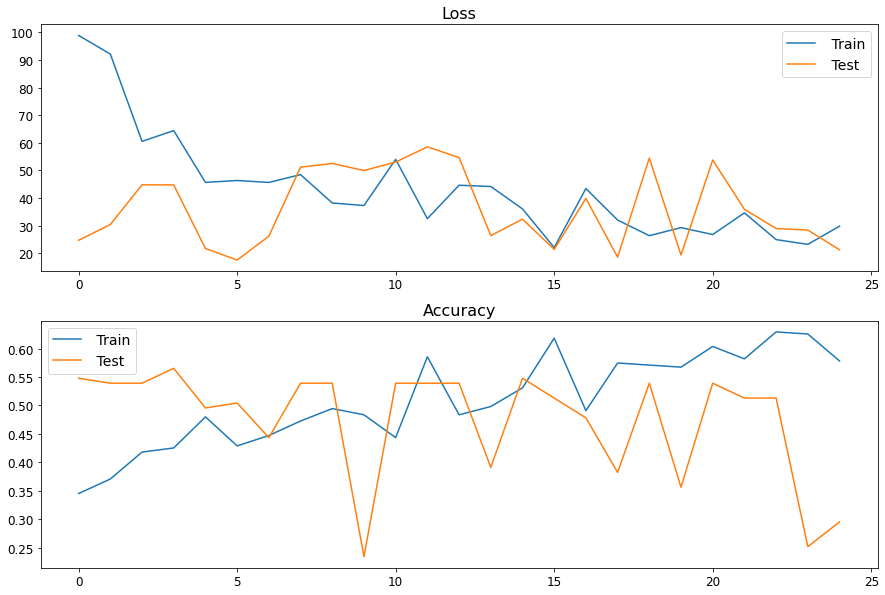

In [17]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

#6. Finetuning the Model by Training all layers
Load a trained model and unfreeze all the layers. Train again to improve the accuracy. 

In [18]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


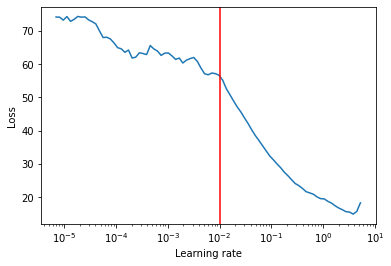

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [20]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9,nesterov=True, weight_decay=1e-4)

# One Cycle Policy
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs
                                          epochs=30,pct_start=0.2, div_factor=10, final_div_factor=100)

In [21]:
model_final, plotData = train_model(model_conv, data, device, criterion, optimizer_conv, scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 70.5855 Acc: 0.3855
val Loss: 381.1973 Acc: 0.1565

Epoch 1/29
----------
train Loss: 24.5471 Acc: 0.3527
val Loss: 61.4521 Acc: 0.5391

Epoch 2/29
----------
train Loss: 6.1273 Acc: 0.3164
val Loss: 25.2083 Acc: 0.4087

Epoch 3/29
----------
train Loss: 4.7773 Acc: 0.3091
val Loss: 21.2548 Acc: 0.1826

Epoch 4/29
----------
train Loss: 2.4686 Acc: 0.3745
val Loss: 20.5437 Acc: 0.1826

Epoch 5/29
----------
train Loss: 2.0786 Acc: 0.4291
val Loss: 5.0334 Acc: 0.1826

Epoch 6/29
----------
train Loss: 1.9053 Acc: 0.4473
val Loss: 5.9823 Acc: 0.4957

Epoch 7/29
----------
train Loss: 1.7038 Acc: 0.4655
val Loss: 6.0414 Acc: 0.5304

Epoch 8/29
----------
train Loss: 1.6020 Acc: 0.4727
val Loss: 2.5315 Acc: 0.5304

Epoch 9/29
----------
train Loss: 1.5443 Acc: 0.4982
val Loss: 2.5293 Acc: 0.4783

Epoch 10/29
----------
train Loss: 1.3334 Acc: 0.5164
val Loss: 4.1122 Acc: 0.5391

Epoch 11/29
----------
train Loss: 1.7896 Acc: 0.5127
val Loss: 3.5089 Acc: 0.5391

Epoch 12/29
----

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


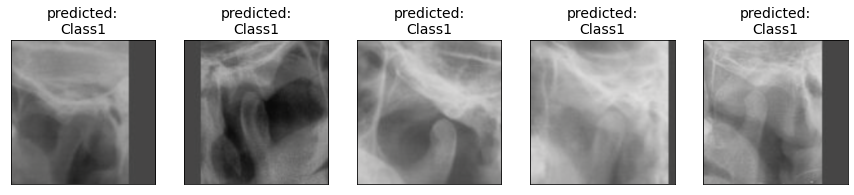

In [22]:
visualize_model(model_res, data, device,"visualize_2.jpg")
plt.ioff()
plt.show()

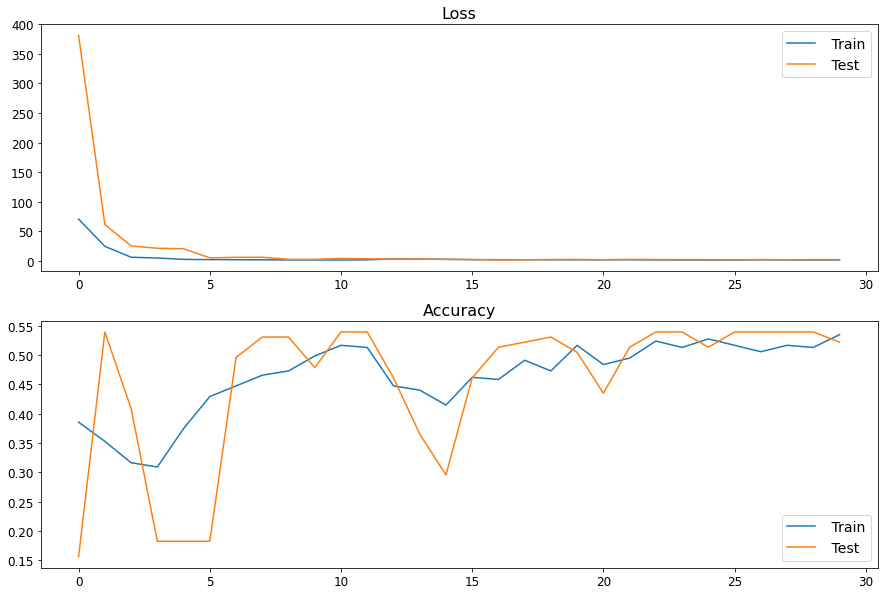

In [23]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

# 7. Plotting Misclassified images

Miss-Classified Images in Class1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


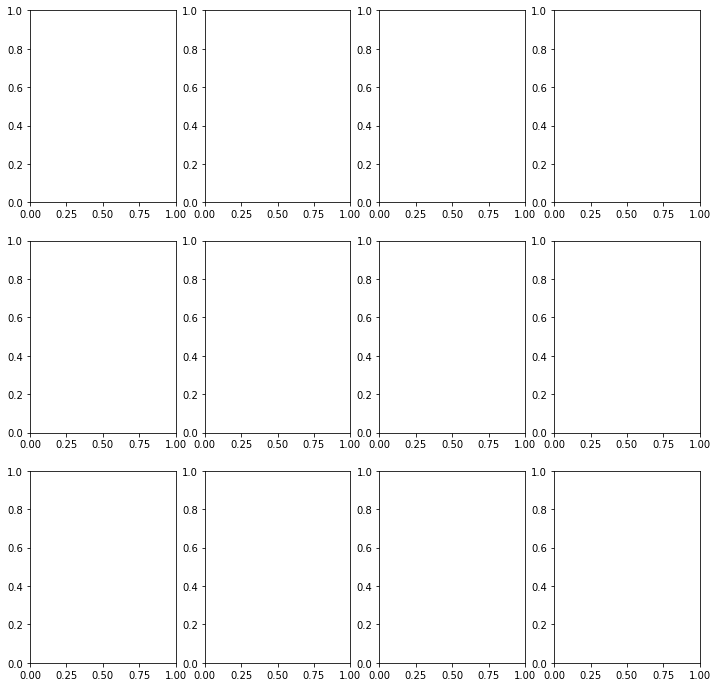

In [25]:
print("Miss-Classified Images in Class1")
ShowMissclassifiedImages(model_final, data,0, device,save_as="MisclassifiedClass1.jpg")

Miss-Classified Images in Large Quadcopters


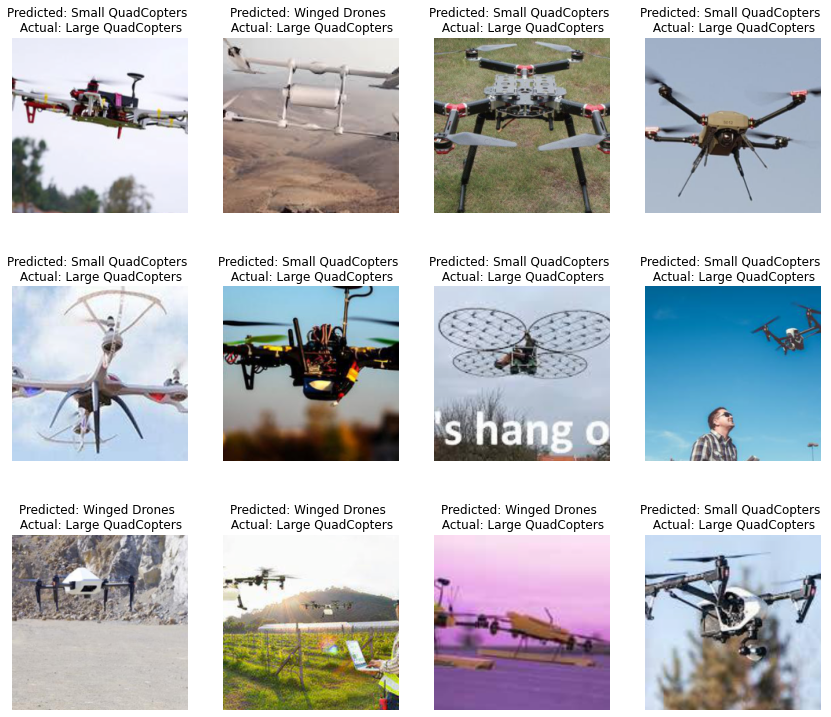

In [ ]:
print("Miss-Classified Images in Large Quadcopters")
ShowMissclassifiedImages(model_final, data,1, device,save_as="MisclassifiedLargeQuadcopter.jpg")

Miss-Classified Images in Small Quadcopters


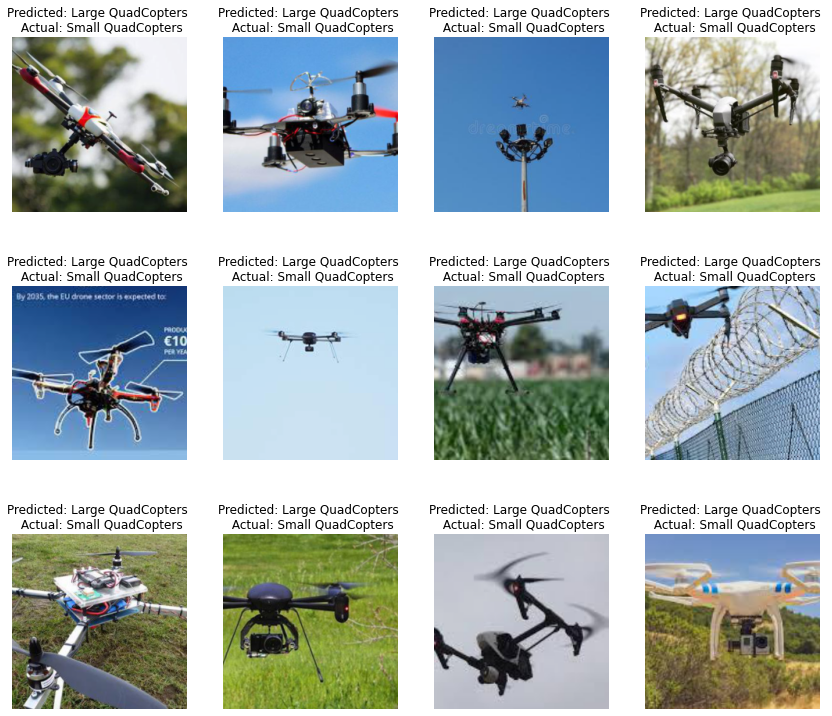

In [ ]:
print("Miss-Classified Images in Small Quadcopters")
ShowMissclassifiedImages(model_final, data,2, device,save_as="MisclassifiedSmallQuadcopter.jpg")

Miss-Classified Images in Winged Drones


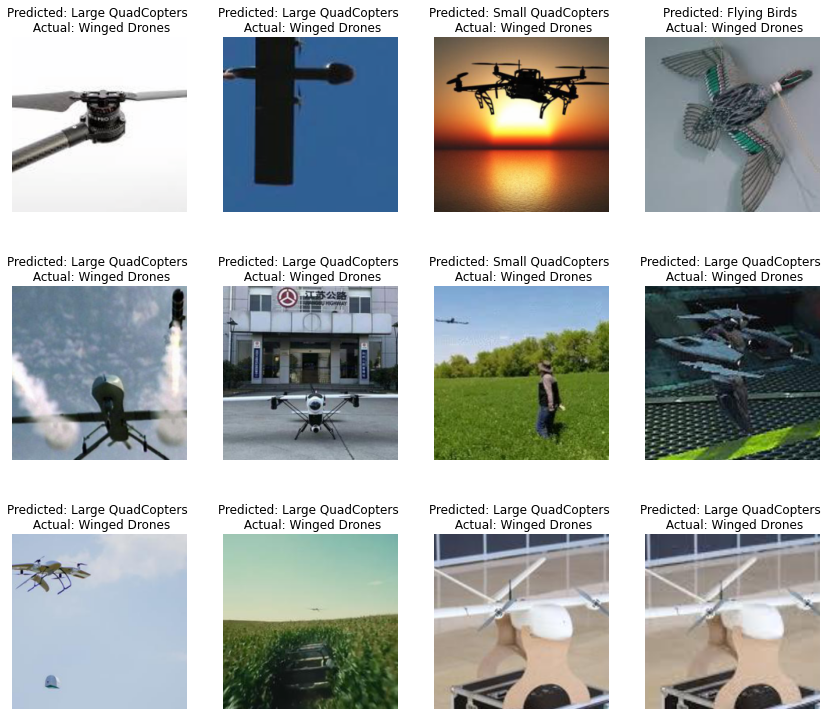

In [ ]:
print("Miss-Classified Images in Winged Drones")
ShowMissclassifiedImages(model_final, data,3, device,save_as="MisclassifiedWingedDrones.jpg")

# 8. Saving Model

In [ ]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v6.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v6.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v6.pt')